## Web Scraping by using text data

- The specific HTML tags which contain the textual content of each news article in the landing page mentioned (https://inshorts.com/). We will be using this information to extract news articles by leveraging the BeautifulSoup and requests libraries. Let’s first load up the following dependencies.

### Steps:
#### 1. Text Documents
#### 2. Text Pre-processing
#### 3. Text Parsing and EDA
#### 4. Text Representaion and Feature Engineering
#### 5. Modelling & Pattern Mining
#### 6. Evaluation & Deployment

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Scraping News Articles for Data Retrieval

- We will now build a function which will leverage requests to access and get the HTML content from the landing pages of each of the three news categories. Then, we will use BeautifulSoup to parse and extract the news headline and article textual content for all the news articles in each category. We find the content by accessing the specific HTML tags and classes, where they are present (a sample of which I depicted in the previous figure).

In [2]:
seed_urls=['https://inshorts.com/en/read/technology',
          'https://inshorts.com/en/read/sports',
          'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data=[]
    for url in seed_urls:
        news_category=url.split('/')[-1]
        data=requests.get(url)
        soup=BeautifulSoup(data.content,'html.parser')
        news_articles=[{'news_headline': headline.find('span',attrs={"itemprop":"headline"}).string,
                        'news_article':article.find('div',attrs={"itemprop":"articleBody"}).string,
                       'news_category':news_category}
                      
                      for headline,article in 
                       zip(soup.find_all('div', class_=["news-card-title news-right-box"]),
                          soup.find_all('div',class_=["news-card-content news-right-box"]))
                      ]
        news_data.extend(news_articles)
    df=pd.DataFrame(news_data)
    df=df[['news_headline','news_article','news_category']]
    return df



- It is pretty clear that we extract the news headline, article text and category and build out a data frame, where each row corresponds to a specific news article. We will now invoke this function and build our dataset.

In [3]:
news_df=build_dataset(seed_urls)
news_df.head()

,news_headline,news_article,news_category
0,"OnePlus to invest ₹1,000 crore in Hyderabad R&...","Opening its first R&D centre in India, OnePlus...",technology
1,Ex-Google engineer charged with theft of self-...,US federal prosecutors on Tuesday charged form...,technology
2,"Apple, Samsung sued in US over handsets' radio...",Apple and Samsung have been sued in the US ove...,technology
3,"Sony, Yamaha partner to develop self-driving c...",Sony and Yamaha have partnered to build the SC...,technology
4,Apple fixes bug that allowed jailbreaking iPho...,Apple has patched a security vulnerability aft...,technology


- We, now, have a neatly formatted dataset of news articles and you can quickly check the total number of news articles with the following code.

In [4]:
news_df.news_category.value_counts()

world         25
sports        25
technology    25
Name: news_category, dtype: int64

### Text Wrangling & Pre-processing

- We will be leveraging a fair bit of nltk and spacy, both state-of-the-art libraries in NLP. 
- Let’s now load up the necessary dependencies for text pre-processing. We will remove negation words from stop words, since we would want to keep them as they might be useful, especially during sentiment analysis.

In [5]:
import nltk
import spacy                                       ## pip install -U spacy
from nltk.tokenize.toktok import ToktokTokenizer
import re
from contractions import CONTRACTION_MAP
import unicodedata
import en_core_web_md   ## python -m spacy download en_core_web_md


nltk.download('stopwords')
nlp = en_core_web_md.load()
#nlp=spacy.load('./en_core_web_md',parse=True,tag=True,entity=True)
tokenizer=ToktokTokenizer()
stopword_list=nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\611806022\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Removing HTML tags

- Often, unstructured text contains a lot of noise, especially if you use techniques like web or screen scraping. HTML tags are typically one of these components which don’t add much value towards understanding and analyzing text.

In [6]:
def strip_html_tag(text):
    soup=BeautifulSoup(text,'html.parser')
    stripped_text=soup.get_text()
    return stripped_text


strip_html_tag('<html><h2>Some important text</h2></html>')

'Some important text'

- It is quite evident from the above output that we can remove unnecessary HTML tags and retain the useful textual information from any document.

### Removing accented characters

- Usually in any text corpus, you might be dealing with accented characters/letters, especially if you only want to analyze the English language. Hence, we need to make sure that these characters are converted and standardized into ASCII characters. A simple example — converting é to e.

In [7]:
def remove_accented_characters(text):
    text=unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_characters('Sómě Áccěntěd těxt')

'Some Accented text'

- The preceding function shows us how we can easily convert accented characters to normal English characters, which helps standardize the words in our corpus.

### Expanding Contractions

- Contractions are shortened version of words or syllables. They often exist in either written or spoken forms in the English language.
- These shortened versions or contractions of words are created by removing specific letters and sounds. In case of English contractions, they are often created by removing one of the vowels from the word. 
- Examples would be, do not to don’t and I would to I’d. Converting each contraction to its expanded, original form helps with text standardization.

In [8]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

- We can see how our function helps expand the contractions from the preceding output. Are there better ways of doing this? Definitely! If we have enough examples, we can even train a deep learning model for better performance.

### Removing Special Characters

- Special characters and symbols are usually non-alphanumeric characters or even occasionally numeric characters (depending on the problem), which add to the extra noise in unstructured text. 
- Usually, simple regular expressions (regexes) can be used to remove them.

In [9]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text
remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

'Well this was fun What do you think '

### Stemming

- Word stems are also known as the base form of a word, and we can create new words by attaching affixes to them in a process known as inflection. 
- Consider the word JUMP. You can add affixes to it and form new words like JUMPS, JUMPED, and JUMPING. In this case, the base word JUMP is the word stem.
- Stem = Jump nad Inflection=Jumping

- The reverse process of obtaining the base form of a word from its inflected form is known as stemming. 
- Stemming helps us in standardizing words to their base or root stem, irrespective of their inflections, which helps many applications like classifying or clustering text, and even in information retrieval. 

 #### Let’s see the popular Porter stemmer in action now!

In [10]:
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text=' '.join([ps.stem(word) for word in text.split()])
    return text

simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

'My system keep crash hi crash yesterday, our crash daili'

- Do note that usually stemming has a fixed set of rules, hence, the root stems may not be lexicographically correct. Which means, the stemmed words "may not be semantically correct", and might have a chance of not being present in the dictionary (as evident from the preceding output).

### Lemmatization

- Lemmatization is very similar to stemming, where we remove word affixes to get to the base form of a word. 
- However, the base form in this case is known as the root word, but not the root stem. 
- The difference being that the root word is always a lexicographically correct word (present in the dictionary), but the root stem may not be so. 
- Thus, root word, also known as the lemma, will always be present in the dictionary. Both nltk and spacy have excellent lemmatizers. We will be using spacy here.

In [11]:
def lemmatize_text(text):
    text = nlp(text)
    text=' '.join([word.lemma_ if word.lemma_ !='-PRON-' else word.text for word in text])
    return text
lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'My system keep crash ! his crashed yesterday , ours crash daily'

- Do note that the lemmatization process is considerably slower than stemming, because an additional step is involved where the root form or lemma is formed by removing the affix from the word if and only if the lemma is present in the dictionary.

### Removing Stopwords

- Words which have little or no significance, especially when constructing meaningful features from text, are known as stopwords or stop words.
- These are usually words that end up having the maximum frequency if you do a simple term or word frequency in a corpus.
- Typically, these can be articles, conjunctions, prepositions and so on. Some examples of stopwords are a, an, the, and the like.

In [12]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

- we use a standard English language stopwords list from nltk. You can also add your own domain-specific stopwords as needed.

### Bringing it all together — Building a Text Normalizer

- While we can definitely keep going with more techniques like correcting spelling, grammar and so on, let’s now bring everything we learnt together and chain these operations to build a text normalizer to pre-process text data.

In [13]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tag(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_characters(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

- Let’s now put this function in action! We will first combine the news headline and the news article text together to form a document for each piece of news. Then, we will pre-process them.

In [14]:
news_df.head()

,news_headline,news_article,news_category
0,"OnePlus to invest ₹1,000 crore in Hyderabad R&...","Opening its first R&D centre in India, OnePlus...",technology
1,Ex-Google engineer charged with theft of self-...,US federal prosecutors on Tuesday charged form...,technology
2,"Apple, Samsung sued in US over handsets' radio...",Apple and Samsung have been sued in the US ove...,technology
3,"Sony, Yamaha partner to develop self-driving c...",Sony and Yamaha have partnered to build the SC...,technology
4,Apple fixes bug that allowed jailbreaking iPho...,Apple has patched a security vulnerability aft...,technology


In [15]:
# combining headline and article text
news_df['full_text']=news_df['news_headline'].map(str)+'. '+news_df['news_article']

# pre-process text and store the same
news_df['clean_text']=normalize_corpus(news_df['full_text'])
norm_corpus=list(news_df['clean_text'])

In [16]:
# show a sample news article
news_df.iloc[1][['full_text', 'clean_text']].to_dict()

{'full_text': "Ex-Google engineer charged with theft of self-driving car tech secrets. US federal prosecutors on Tuesday charged former Google engineer Anthony Levandowski with 33 counts of theft and attempted theft of self-driving car technology secrets before he joined Uber. If convicted, he faces 10 years in jail, a $250,000 fine, plus restitution, for each violation. Levandowski was a founding member of the group that worked on Google's self-driving car project Waymo.",
 'clean_text': 'ex google engineer charge theft self drive car tech secret us federal prosecutor tuesday charge former google engineer anthony levandowski count theft attempt theft self drive car technology secret join uber convict face year jail fine plus restitution violation levandowski found member group work google self drive car project waymo'}

In [17]:
news_df.to_csv('news.csv', index=False, encoding='utf-8')

### Understanding Language Syntax and Structure


- Typical parsing techniques for understanding text syntax are mentioned below.
- Parts of Speech (POS) Tagging
- Shallow Parsing or Chunking
- Constituency Parsing
- Dependency Parsing


### speech tagging or POS tagging 

- POS tags are used to annotate words and depict their POS, which is really helpful to perform specific analysis, such as narrowing down upon nouns and seeing which ones are the most prominent, word sense disambiguation, and grammar analysis. 

- Generally, words fall into below categories.

- N: - Noun
- V :Verb
- Adj: Adjective
- Adv: Adverb
- Singular nouns= NN
- singular proper nouns:NNP
- plural nouns= NNs





- The process of classifying and labeling POS tags for words called parts of speech tagging or POS tagging . 
- POS tags are used to annotate words and depict their POS, which is really helpful to perform specific analysis, such as narrowing down upon nouns and seeing which ones are the most prominent, word sense disambiguation, and grammar analysis. We will be leveraging both nltk and spacy 


In [18]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\611806022\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [19]:



# create a basic pre-processed corpus, don't lowercase to get POS context
corpus=normalize_corpus(news_df["full_text"],text_lower_case=False,text_lemmatization=False,special_char_removal=False)

# demo for POS tagging for sample news headline
sentence=str(news_df.iloc[1].news_headline)
sentence_nlp=nlp(sentence)

# POS tagging with Spacy
spacy_pos_tagged=[(word,word.tag_,word.pos_) for word in sentence_nlp]
Df_POSTag_Spacy=pd.DataFrame(spacy_pos_tagged,columns=['Word', 'POS tag', 'Tag type'])

#POS tagging with nltk
nltk_pos_tagged = nltk.pos_tag(sentence.split())
Df_PosTag_nltk=pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag'])

In [20]:
Df_PosTag_nltk

,Word,POS tag
0,Ex-Google,NNP
1,engineer,NN
2,charged,VBN
3,with,IN
4,theft,NN
5,of,IN
6,self-driving,JJ
7,car,NN
8,tech,NN
9,secrets,NNS


In [21]:
Df_POSTag_Spacy

,Word,POS tag,Tag type
0,Ex,NNP,PROPN
1,-,NNP,PROPN
2,Google,NNP,PROPN
3,engineer,NN,NOUN
4,charged,VBD,VERB
5,with,IN,ADP
6,theft,NN,NOUN
7,of,IN,ADP
8,self,NN,NOUN
9,-,HYPH,PUNCT


- We can see that each of these libraries treat tokens in their own way and assign specific tags for them. Based on what we see, spacy seems to be doing slightly better than nltk.

### Shallow Parsing or Chunking

There are five major categories of phrases:
- Noun phrase (NP)
- Verb phrase (VP)
- Adjective phrase (AP)
- Adverb phrase (ADVP)
- Prepositional phrase (PP)


- Shallow parsing, also known as light parsing or chunking , is a popular natural language processing technique of analyzing the structure of a sentence to break it down into its smallest constituents (which are tokens such as words) and group them together into higher-level phrases. 
- This includes POS tags as well as phrases from a sentence.


- We will leverage the conll2000 corpus for training our shallow parser model. This corpus is available in nltk with chunk annotations and we will be using around 10K records for training our model. A sample annotated sentence is depicted as follows.

In [22]:
from nltk.corpus import conll2000
data=conll2000.chunked_sents()
train_data=data[:10900]
test_data=data[10900:]
print(train_data[0])

(S
  (NP Confidence/NN)
  (PP in/IN)
  (NP the/DT pound/NN)
  (VP is/VBZ widely/RB expected/VBN to/TO take/VB)
  (NP another/DT sharp/JJ dive/NN)
  if/IN
  (NP trade/NN figures/NNS)
  (PP for/IN)
  (NP September/NNP)
  ,/,
  due/JJ
  (PP for/IN)
  (NP release/NN)
  (NP tomorrow/NN)
  ,/,
  (VP fail/VB to/TO show/VB)
  (NP a/DT substantial/JJ improvement/NN)
  (PP from/IN)
  (NP July/NNP and/CC August/NNP)
  (NP 's/POS near-record/JJ deficits/NNS)
  ./.)


In [23]:
conll2000.fileids

<bound method CorpusReader.fileids of <ConllChunkCorpusReader in 'C:\\Users\\611806022\\AppData\\Roaming\\nltk_data\\corpora\\conll2000'>>

- From the preceding output, you can see that our data points are sentences that are already annotated with phrases and POS tags metadata that will be useful in training our shallow parser model. 
- We will leverage two chunking utility functions, tree2conlltags , to get triples of word, tag, and chunk tags for each token, and conlltags2tree to generate a parse tree from these token triples.
- We will be using these functions to train our parser. A sample is depicted below.

In [24]:
from nltk.chunk.util import tree2conlltags,conlltags2tree
wtc=tree2conlltags(train_data[1])
wtc
                   

[('Chancellor', 'NNP', 'O'),
 ('of', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('Exchequer', 'NNP', 'I-NP'),
 ('Nigel', 'NNP', 'B-NP'),
 ('Lawson', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('restated', 'VBN', 'I-NP'),
 ('commitment', 'NN', 'I-NP'),
 ('to', 'TO', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('firm', 'NN', 'I-NP'),
 ('monetary', 'JJ', 'I-NP'),
 ('policy', 'NN', 'I-NP'),
 ('has', 'VBZ', 'B-VP'),
 ('helped', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('prevent', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('freefall', 'NN', 'I-NP'),
 ('in', 'IN', 'B-PP'),
 ('sterling', 'NN', 'B-NP'),
 ('over', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('past', 'JJ', 'I-NP'),
 ('week', 'NN', 'I-NP'),
 ('.', '.', 'O')]

- The chunk tags use the IOB format. This notation represents Inside, Outside, and Beginning.
- The B- prefix before a tag indicates it is the beginning of a chunk, and I- prefix indicates that it is inside a chunk. The O tag indicates that the token does not belong to any chunk. 
- The B- tag is always used when there are subsequent tags of the same type following it without the presence of O tags between them.



---  We will now define a function conll_tag_ chunks() to extract POS and chunk tags from sentences with chunked annotations and a function called combined_taggers() to train multiple taggers with backoff taggers (e.g. unigram and bigram taggers)

In [25]:
def conll_tag_chunks(chunk_sents):
    tagged_sents=[tree2conlltags(tree) for tree in chunk_sents]
    return [[(t,c) for (w,t,c) in sent] for sent in tagged_sents]
def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff 

- We will now define a class NGramTagChunker that will take in tagged sentences as training input, get their (word, POS tag, Chunk tag) WTC triples, and train a BigramTagger with a UnigramTagger as the backoff tagger. 
- We will also define a parse() function to perform shallow parsing on new sentences.

###### The UnigramTagger , BigramTagger , and TrigramTagger are classes that inherit from the base class NGramTagger , which itself inherits from the ContextTagger class , which inherits from the SequentialBackoffTagger class .


- We will use this class to train on the conll2000 chunked train_data and evaluate the model performance on the test_data

In [26]:
from nltk.tag import UnigramTagger,BigramTagger
from nltk.chunk import ChunkParserI

# define the chunker class
class NGramTagChunker(ChunkParserI):
    
    def __init__(self, train_sentences,
                 tagger_classes=[UnigramTagger,BigramTagger]
                ):
        train_sent_tags=conll_tag_chunks(train_sentences)
        self.chunk_tagger=combined_tagger(train_sent_tags,tagger_classes)
        
        
    def parse(self, tagged_sentence):
        if not tagged_sentence: 
            return None
        pos_tags = [tag for word, tag in tagged_sentence]
        chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
        chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
        wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                     in zip(tagged_sentence, chunk_tags)]
        return conlltags2tree(wpc_tags)
    #train chunker model
ntc = NGramTagChunker(train_data)
    
    #evaluate chunker model performance
print(ntc.evaluate(test_data))
        



ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


- Our chunking model gets an accuracy of around 90% which is quite good! Let’s now leverage this model to shallow parse and chunk our sample news article headline which we used earlier

In [27]:
chunk_tree=ntc.parse(nltk_pos_tagged)
print(chunk_tree)

(S
  (NP Ex-Google/NNP engineer/NN)
  (VP charged/VBN)
  (PP with/IN)
  (NP theft/NN)
  (PP of/IN)
  (NP self-driving/JJ car/NN tech/NN secrets/NNS))


### Named Entity Recognition

- In any text document, there are particular terms that represent specific entities that are more informative and have a unique context. 
- These entities are known as named entities , which more specifically refer to terms that represent real-world objects like people, places, organizations, and so on, which are often denoted by proper names.
- A naive approach could be to find these by looking at the noun phrases in text documents.
- Named entity recognition (NER) , also known as entity chunking/extraction , is a popular technique used in information extraction to identify and segment the named entities and classify or categorize them under various predefined classes.


- SpaCy has some excellent capabilities for named entity recognition. Let’s try and use it on one of our sample news articles.

In [31]:
from spacy import displacy
sentence=str(news_df.iloc[1].full_text)
sentence_nlp=nlp(sentence)

#print name entities in the article
print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])
# visualize named entities
displacy.render(sentence_nlp, style='ent', jupyter=True)

[(US, 'GPE'), (Tuesday, 'DATE'), (Google, 'ORG'), (Anthony, 'PERSON'), (Levandowski, 'PERSON'), (33, 'CARDINAL'), (Uber, 'PERSON'), (10, 'DATE'), (years, 'DATE'), (250,000, 'MONEY'), (Levandowski, 'PERSON'), (Google, 'ORG'), (Waymo, 'PRODUCT')]


- We can clearly see that the major named entities have been identified by spacy. 

- Let’s now find out the most frequent named entities in our news corpus! For this, we will build out a data frame of all the named entities and their types using the following code.

In [32]:
named_entities = []
for sentence in corpus:
    temp_entity_name = ''
    temp_named_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])

- We can now transform and aggregate this data frame to find the top occuring entities and types.

In [33]:
top_entities=(entity_frame.groupby(by=['Entity Name','Entity Type'])
             .size()
             .sort_values(ascending=False)
             .reset_index().rename(columns={0:'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,US,Amazon,Apple,Brazil,India,Indian,Pakistan,first,Instagram,China,Hong Kong,French,second,Sumit Nagal,Bumrah
Entity Type,GPE,ORG,ORG,GPE,GPE,NORP,GPE,ORDINAL,ORG,GPE,GPE,NORP,ORDINAL,PERSON,ORG
Frequency,26,20,14,13,12,11,9,8,8,7,6,6,5,5,5


In [34]:
# get the top named entity types
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Type,PERSON,ORG,GPE,DATE,NORP,CARDINAL,MONEY,ORDINAL,EVENT,LOC,PRODUCT,QUANTITY,TIME,LANGUAGE,WORK_OF_ART
Frequency,181,178,134,62,60,48,29,21,9,8,6,3,2,2,2


- We can see that people, places and organizations are the most mentioned entities though interestingly we also have many other entities.

## Emotion and Sentiment Analysis

- sentiment analysis for text data can be computed on several levels, including on an individual sentence level, paragraph level, or the entire document as a whole. Often, sentiment is computed on the document as a whole or some aggregations are done after computing the sentiment for individual sentences.

- There are two major approaches to sentiment analysis.

#####  1. Supervised machine learning or deep learning approaches
#####  2. Unsupervised lexicon-based approaches


### Unsupervised lexicon-based approaches

- In this scenario, we do not have the convenience of a well-labeled training dataset. Hence, we will need to use unsupervised techniques for predicting the sentiment by using knowledgebases, ontologies, databases, and lexicons that have detailed information, specially curated and prepared just for sentiment analysis.

- A lexicon is a dictionary, vocabulary, or a book of words. In our case, lexicons are special dictionaries or vocabularies that have been created for analyzing sentiments.

- Most of these lexicons have a list of positive and negative polar words with some score associated with them, and using various techniques like the position of words, surrounding words, context, parts of speech, phrases, and so on, scores are assigned to the text documents for which we want to compute the sentiment. After aggregating these scores, we get the final sentiment.


- Various popular lexicons are used for sentiment analysis, including the following.
- AFINN lexicon
- Bing Liu’s lexicon
- MPQA subjectivity lexicon
- SentiWordNet
- VADER lexicon
- TextBlob lexicon


### Sentiment Analysis with AFINN Lexicon

In [37]:
# initialize afinn sentiment analyzer
from afinn import Afinn
af=Afinn()

# compute sentiment scores (polarity) and labels
sentiment_scores=[af.score(article) for article in corpus]
sentiment_category=['positive' if score>0
                   else 'negative' if score<0
                   else 'neutral'
                   for score in sentiment_scores]

# sentiment statistics per news category
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores, sentiment_category]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                           
                        count  mean       std   min  25%  50%  75%   max
news_category                                                           
sports                   25.0  4.16  7.197685  -9.0  0.0  4.0  9.0  20.0
technology               25.0 -2.44  6.110646 -15.0 -5.0 -2.0  1.0  11.0
world                    25.0 -2.48  4.788180 -15.0 -5.0 -3.0  0.0   9.0

We can get a good idea of general sentiment statistics across different news categories. Looks like the average sentiment is very positive in sports and reasonably negative in technology! Let’s look at some visualizations now.

In [39]:
df.head()

,news_category,sentiment_score,sentiment_category
0,technology,8.0,positive
1,technology,-8.0,negative
2,technology,-10.0,negative
3,technology,0.0,neutral
4,technology,-12.0,negative


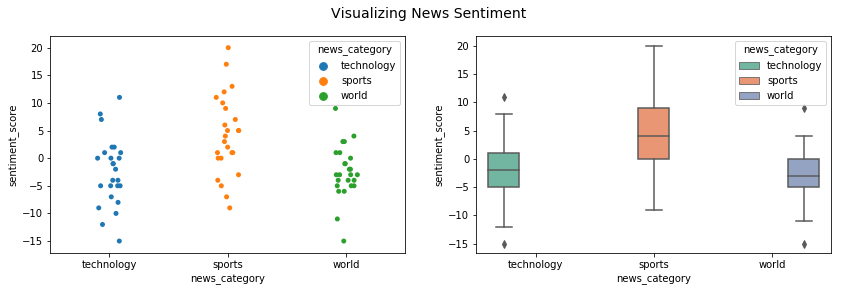

In [40]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='news_category', y="sentiment_score", 
                   hue='news_category', data=df, ax=ax1)
bp = sns.boxplot(x='news_category', y="sentiment_score", 
                 hue='news_category', data=df, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing News Sentiment', fontsize=14)

We can see that the spread of sentiment polarity is much higher in sports and technology as compared to world where a lot of the articles seem to be having a negative polarity. We can also visualize the frequency of sentiment labels.

C:\Users\611806022\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


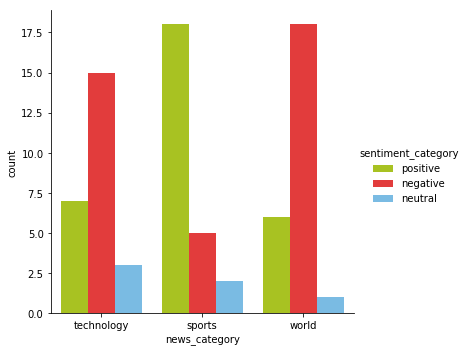

In [41]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [58]:

pos_idx = df[(df.news_category=='technology') & (df.sentiment_score == 11)].index[-1]
neg_idx = df[(df.news_category=='technology') & (df.sentiment_score == -2.44)].index[2]
print('Most Negative Tech News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive Tech News Article:', news_df.iloc[pos_idx][['news_article']][0])

IndexError: index 2 is out of bounds for axis 0 with size 0

In [50]:
pos_idx = df[(df.news_category=='technology') & (df.sentiment_score == 11)]

In [51]:
pos_idx

,news_category,sentiment_score,sentiment_category
11,technology,11.0,positive


### Sentiment Analysis with TextBlob

TextBlob is another excellent open-source library for performing NLP tasks with ease, including sentiment analysis. It also an a sentiment lexicon (in the form of an XML file) which it leverages to give both polarity and subjectivity scores. Typically, the scores have a normalized scale as compare to Afinn. The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective. Let’s use this now to get the sentiment polarity and labels for each news article and aggregate the summary statistics per news category.

In [60]:
from textblob import TextBlob

# compute sentiment scores (polarity) and labels
sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in news_df['clean_text']]
sentiment_category_tb = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores_tb]


# sentiment statistics per news category
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                                \
                        count     mean       std   min    25%    50%    75%   
news_category                                                                 
sports                   25.0  0.13564  0.133349 -0.10  0.070  0.115  0.250   
technology               25.0  0.04948  0.185731 -0.54  0.000  0.043  0.200   
world                    25.0  0.03132  0.171586 -0.24 -0.067 -0.008  0.137   

                      
                 max  
news_category         
sports         0.400  
technology     0.378  
world          0.500

In [62]:
df.head()

,news_category,sentiment_score,sentiment_category
0,technology,0.079,positive
1,technology,-0.097,negative
2,technology,0.200,positive
3,technology,0.031,positive
4,technology,-0.100,negative


C:\Users\611806022\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


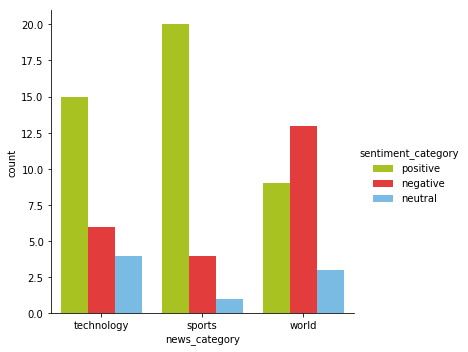

In [63]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})